### Query prompt

* `Prompt Query Mecanism` de Segment Any Change
* N prompt utilisateur en paramètres (3 par défaut)
* Objets des prompts sont matchés (cosine sim) avec les objets de changements extraits via le Bitemporal Matching

In [18]:
from segment_any_change.config_run import load_exp_params

import numpy as np
import cv2
from PIL import Image
import torch
from magic_pen.config import SEED
import pytorch_lightning as pl
import pandas as pd
import os
from copy import deepcopy
import torch.nn.functional as F
from torchmetrics import Metric
from tqdm import tqdm
import torch
import matplotlib.pyplot as plt
from dataclasses import asdict

from commons.constants import NamedDataset, NamedModels

from magic_pen.utils_io import load_levircd_sample
from magic_pen.data.loader import BiTemporalDataset
from magic_pen.config import DEVICE
from magic_pen.data.loader import BiTemporalDataset
from magic_pen.data.process import DefaultTransform
from magic_pen.utils_io import save_pickle, load_pickle

from segment_any_change.masks.mask_process import extract_object_from_batch
from segment_any_change.utils import to_numpy, SegAnyChangeVersion, show_img, show_pair_img, show_prediction_sample
from segment_any_change.inference import partial_inference, infer_on_sample, load_partial_ds
from segment_any_change.query_prompt import SegAnyPrompt
from segment_any_change.matching import BitemporalMatching
from segment_any_change.config_run import load_sam, load_default_exp_params, ExperimentParams, choose_model, load_default_metrics, load_exp_params
from segment_any_change.model import BiSam

from torch.profiler import profile, record_function, ProfilerActivity

pl.seed_everything(seed=SEED)

2024-06-21 17:32:48,994 - INFO ::  Seed set to 12


12

In [21]:
ds_dtype = "train"

params = dict(
    batch_size=2,
    ds_name="levir-cd",
    dev=False,
    n_job_by_node=2,
    th_change_proposals=60,
    prompt_type="sample",
    n_prompt=3,
    loc="random",
    pred_iou_thresh=0.7,
    stability_score_thresh=0.7,
    n_points_grid=1024,
    th_sim=0.8,
    model_name=NamedModels.SEGANYPROMPT.value
)
params = load_exp_params(**params)
print(params)

ExperimentParams(model_name='segany', model_type='vit_b', batch_size=2, output_dir='/home/MDizier/projects/stage_stylo_magique_2024/lightning_logs/seganychange/levir-cd/predictions-vit_h', logs_dir='/home/MDizier/projects/stage_stylo_magique_2024/lightning_logs/seganychange/levir-cd/seganychange_repr_change_th', ds_name='levir-cd', th_change_proposals=60, seganychange_version=<SegAnyChangeVersion.AUTHOR: 'v2'>, col_nms_threshold='ci', th_sim=0.8, n_points_grid=1024, prompt_type='sample', n_prompt=3, pred_iou_thresh=0.7, stability_score_thresh=0.7, stability_score_offset=1.0, box_nms_thresh=0.7, min_mask_region_area=0, engine_metric={'iou_type_mAP': 'segm', 'type_decision_mAP': 'ci', 'max_detection_thresholds': [10, 100, 1000]}, exp_id='20240621_173446', exp_name='seganychange_repr_change_th', num_worker=2, n_job_by_node=2, dev=True, loc='random')


In [22]:
indices = np.random.randint(0, 100, 4)
# indices = [71, 115, 54, 46]
print(indices)
#

ds = load_partial_ds(params.ds_name, ds_dtype, params, indices)

dloader = torch.utils.data.DataLoader(
    ds, batch_size=params.batch_size, shuffle=False
)

sam = load_sam(
    model_type=params.model_type, model_cls=BiSam, version="dev", device=DEVICE
)
matching_engine = BitemporalMatching(
            model=sam,
            version=params.seganychange_version,
            **asdict(params)
        )

engine = SegAnyPrompt(matching_engine, **asdict(params))
outputs = []
for i, batch in tqdm(enumerate(dloader), total=len(dloader), desc="Processing"):
    with torch.no_grad():
        with profile(activities=[ProfilerActivity.CPU],profile_memory=True, record_shapes=True) as prof:
            preds = engine(batch)
        print(prof.key_averages().table(sort_by="self_cpu_memory_usage", row_limit=10))

        outputs.append({"pred":preds, "batch":batch})

2024-06-21 17:34:46,914 - INFO ::  build vit_b BiSam


[ 2  3 67 76]
DATASET SUBSET : 4


Processing:   0%|                                                                 | 0/2 [00:00<?, ?it/s][W kineto_shim.cpp:333] Adding profiling metadata requires using torch.profiler with Kineto support (USE_KINETO=1)
[W kineto_shim.cpp:333] Adding profiling metadata requires using torch.profiler with Kineto support (USE_KINETO=1)
2024-06-21 17:34:49,436 - INFO ::  === v2 ====


BATCH SIZE : 2 * 2
dict_keys(['img_A', 'img_B', 'label', 'index', 'point_coords', 'point_labels'])
Mode : auto
DTYPE input model torch.float32
Function forward Took 4.5647 seconds
sparse_embeddings: torch.Size([4, 1024, 2, 256])
dense_embeddings: torch.Size([4, 1024, 256, 64, 64])
--in transformer--
src : torch.Size([4, 1024, 256, 64, 64])
pos_src : torch.Size([4, 1024, 256, 64, 64])
tokens : torch.Size([4, 1024, 7, 256])
Function predict_masks_batch Took 42.5519 seconds
OUT MODEL : torch.Size([4, 1024, 3, 256, 256])
:: raw masks : 3072 ::
 filter iou_th : 1958
 filter stability_score : 1452
 filter mask_threshold : 1452
ATTACH 582 masks
:: raw masks : 3072 ::
 filter iou_th : 1973
 filter stability_score : 862
 filter mask_threshold : 862
ATTACH 412 masks
:: raw masks : 3072 ::
 filter iou_th : 1313
 filter stability_score : 1037
 filter mask_threshold : 1037
ATTACH 565 masks
:: raw masks : 3072 ::
 filter iou_th : 1839
 filter stability_score : 811
 filter mask_threshold : 811


2024-06-21 17:35:36,987 - INFO ::  Function generate Took 47.5497 seconds


ATTACH 405 masks


2024-06-21 17:35:42,756 - INFO ::  Function temporal_matching_torch Took 5.7674 seconds
2024-06-21 17:35:48,332 - INFO ::  Function temporal_matching_torch Took 5.5744 seconds
2024-06-21 17:35:48,362 - INFO ::  Function proposal_matching_nms Took 0.0104 seconds


NMS masks fusion
masks torch.Size([2, 582, 256, 256])
masks i A torch.Size([582, 256, 256])
masks i B torch.Size([565, 256, 256])
ci torch.Size([2, 582])
bboxes torch.Size([2, 582, 4])
ious torch.Size([2, 582])
masks_logits torch.Size([2, 582, 256, 256])


2024-06-21 17:35:52,461 - INFO ::  Function temporal_matching_torch Took 4.0794 seconds
2024-06-21 17:35:56,481 - INFO ::  Function temporal_matching_torch Took 4.0194 seconds
2024-06-21 17:35:56,504 - INFO ::  Function proposal_matching_nms Took 0.0071 seconds


NMS masks fusion
masks torch.Size([2, 412, 256, 256])
masks i A torch.Size([412, 256, 256])
masks i B torch.Size([405, 256, 256])
ci torch.Size([2, 412])
bboxes torch.Size([2, 412, 4])
ious torch.Size([2, 412])
masks_logits torch.Size([2, 412, 256, 256])


2024-06-21 17:35:56,937 - INFO ::  Function run Took 67.4996 seconds


Mode : auto
DTYPE input model torch.float32
Function forward Took 2.2367 seconds
sparse_embeddings: torch.Size([2, 3, 2, 256])
dense_embeddings: torch.Size([2, 3, 256, 64, 64])
--in transformer--
src : torch.Size([2, 3, 256, 64, 64])
pos_src : torch.Size([2, 3, 256, 64, 64])
tokens : torch.Size([2, 3, 7, 256])
Function predict_masks_batch Took 0.1426 seconds
torch.Size([2, 256])
torch.Size([2, 621, 256])
2


Processing:  50%|████████████████████████████▌                            | 1/2 [01:13<01:13, 73.86s/it]

-------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                           Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg       CPU Mem  Self CPU Mem    # of Calls  
-------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
            aten::empty_strided         0.00%       2.429ms         0.00%       2.429ms       4.627us     494.42 Gb     494.42 Gb           525  
                    aten::empty         0.02%      11.216ms         0.02%      11.216ms      10.702us     441.14 Gb     441.14 Gb          1048  
                      aten::add         7.46%        5.006s         7.46%        5.006s      22.550ms     186.73 Gb     186.73 Gb           222  
                       aten::mm        27.80%       18.648s        27.80%       18.648s     103.600ms     105.10 Gb     105.

[W kineto_shim.cpp:333] Adding profiling metadata requires using torch.profiler with Kineto support (USE_KINETO=1)
[W kineto_shim.cpp:333] Adding profiling metadata requires using torch.profiler with Kineto support (USE_KINETO=1)
2024-06-21 17:36:03,112 - INFO ::  === v2 ====


BATCH SIZE : 2 * 2
dict_keys(['img_A', 'img_B', 'label', 'index', 'point_coords', 'point_labels'])
Mode : auto
DTYPE input model torch.float32
Function forward Took 4.6728 seconds
sparse_embeddings: torch.Size([4, 1024, 2, 256])
dense_embeddings: torch.Size([4, 1024, 256, 64, 64])
--in transformer--
src : torch.Size([4, 1024, 256, 64, 64])
pos_src : torch.Size([4, 1024, 256, 64, 64])
tokens : torch.Size([4, 1024, 7, 256])
Function predict_masks_batch Took 43.9844 seconds
OUT MODEL : torch.Size([4, 1024, 3, 256, 256])
:: raw masks : 3072 ::
 filter iou_th : 2130
 filter stability_score : 872
 filter mask_threshold : 872
ATTACH 390 masks
:: raw masks : 3072 ::
 filter iou_th : 1784
 filter stability_score : 1159
 filter mask_threshold : 1159
ATTACH 634 masks
:: raw masks : 3072 ::
 filter iou_th : 1925
 filter stability_score : 815
 filter mask_threshold : 815
ATTACH 436 masks
:: raw masks : 3072 ::
 filter iou_th : 1721


2024-06-21 17:36:52,217 - INFO ::  Function generate Took 49.1042 seconds


 filter stability_score : 1356
 filter mask_threshold : 1356
ATTACH 761 masks


2024-06-21 17:36:56,084 - INFO ::  Function temporal_matching_torch Took 3.8640 seconds
2024-06-21 17:37:00,392 - INFO ::  Function temporal_matching_torch Took 4.3072 seconds
2024-06-21 17:37:00,414 - INFO ::  Function proposal_matching_nms Took 0.0081 seconds


NMS masks fusion
masks torch.Size([2, 436, 256, 256])
masks i A torch.Size([390, 256, 256])
masks i B torch.Size([436, 256, 256])
ci torch.Size([2, 436])
bboxes torch.Size([2, 436, 4])
ious torch.Size([2, 436])
masks_logits torch.Size([2, 436, 256, 256])


2024-06-21 17:37:06,682 - INFO ::  Function temporal_matching_torch Took 6.2509 seconds
2024-06-21 17:37:14,178 - INFO ::  Function temporal_matching_torch Took 7.4944 seconds
2024-06-21 17:37:14,215 - INFO ::  Function proposal_matching_nms Took 0.0136 seconds


NMS masks fusion
masks torch.Size([2, 761, 256, 256])
masks i A torch.Size([634, 256, 256])
masks i B torch.Size([761, 256, 256])
ci torch.Size([2, 761])
bboxes torch.Size([2, 761, 4])
ious torch.Size([2, 761])
masks_logits torch.Size([2, 761, 256, 256])


2024-06-21 17:37:14,930 - INFO ::  Function run Took 71.8172 seconds


Mode : auto
DTYPE input model torch.float32
Function forward Took 2.2192 seconds
sparse_embeddings: torch.Size([2, 3, 2, 256])
dense_embeddings: torch.Size([2, 3, 256, 64, 64])
--in transformer--
src : torch.Size([2, 3, 256, 64, 64])
pos_src : torch.Size([2, 3, 256, 64, 64])
tokens : torch.Size([2, 3, 7, 256])
Function predict_masks_batch Took 0.1464 seconds
torch.Size([2, 256])
torch.Size([2, 1045, 256])
2


Processing: 100%|█████████████████████████████████████████████████████████| 2/2 [02:31<00:00, 75.98s/it]

-------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                           Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg       CPU Mem  Self CPU Mem    # of Calls  
-------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
            aten::empty_strided         0.00%       2.727ms         0.00%       2.727ms       5.194us     558.81 Gb     558.81 Gb           525  
                    aten::empty         0.01%      10.395ms         0.01%      10.395ms       9.947us     474.17 Gb     474.17 Gb          1045  
                      aten::add         7.17%        5.117s         7.17%        5.117s      23.052ms     186.73 Gb     186.73 Gb           222  
                       aten::mm        26.86%       19.175s        26.86%       19.175s     106.527ms     105.10 Gb     105.

## VIT-b

### 4

In [23]:
print(params)

ExperimentParams(model_name='segany', model_type='vit_b', batch_size=2, output_dir='/home/MDizier/projects/stage_stylo_magique_2024/lightning_logs/seganychange/levir-cd/predictions-vit_h', logs_dir='/home/MDizier/projects/stage_stylo_magique_2024/lightning_logs/seganychange/levir-cd/seganychange_repr_change_th', ds_name='levir-cd', th_change_proposals=60, seganychange_version=<SegAnyChangeVersion.AUTHOR: 'v2'>, col_nms_threshold='ci', th_sim=0.8, n_points_grid=1024, prompt_type='sample', n_prompt=3, pred_iou_thresh=0.7, stability_score_thresh=0.7, stability_score_offset=1.0, box_nms_thresh=0.7, min_mask_region_area=0, engine_metric={'iou_type_mAP': 'segm', 'type_decision_mAP': 'ci', 'max_detection_thresholds': [10, 100, 1000]}, exp_id='20240621_173446', exp_name='seganychange_repr_change_th', num_worker=2, n_job_by_node=2, dev=True, loc='random')


tensor([809., 831.])
tensor([857., 858.])
tensor([546., 887.])


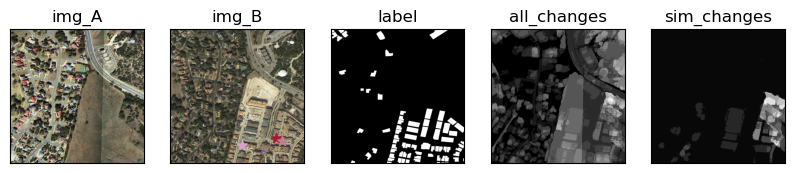

In [24]:
show_prediction_sample(outputs[0], idx=0)

tensor([ 40., 976.])
tensor([876., 921.])
tensor([ 189., 1018.])


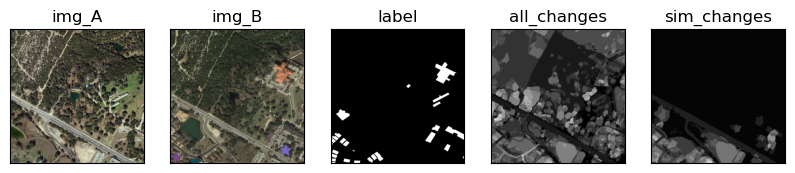

In [25]:
show_prediction_sample(outputs[0], idx=1)

tensor([605.,  76.])
tensor([938.,  60.])
tensor([736.,  65.])


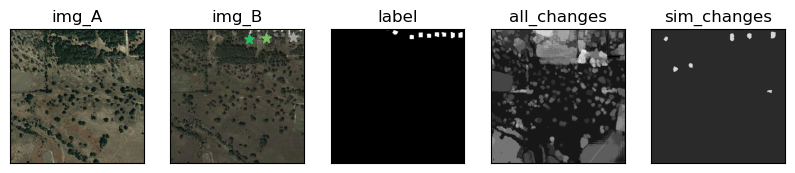

In [26]:
show_prediction_sample(outputs[1], idx=0)

tensor([941., 168.])
tensor([835., 127.])
tensor([875., 127.])


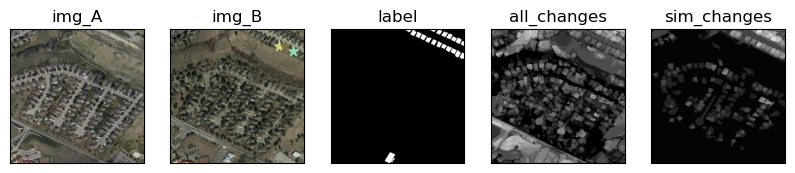

In [27]:
show_prediction_sample(outputs[1], idx=1)

### 3

In [12]:
print(params)

ExperimentParams(model_name='segany', model_type='vit_b', batch_size=2, output_dir='/home/MDizier/projects/stage_stylo_magique_2024/lightning_logs/seganychange/levir-cd/predictions-vit_h', logs_dir='/home/MDizier/projects/stage_stylo_magique_2024/lightning_logs/seganychange/levir-cd/seganychange_repr_change_th', ds_name='levir-cd', th_change_proposals=60, seganychange_version=<SegAnyChangeVersion.AUTHOR: 'v2'>, col_nms_threshold='ci', th_sim=0.8, n_points_grid=1024, prompt_type='sample', n_prompt=3, pred_iou_thresh=0.7, stability_score_thresh=0.7, stability_score_offset=1.0, box_nms_thresh=0.7, min_mask_region_area=0, engine_metric={'iou_type_mAP': 'segm', 'type_decision_mAP': 'ci', 'max_detection_thresholds': [10, 100, 1000]}, exp_id='20240621_172224', exp_name='seganychange_repr_change_th', num_worker=2, n_job_by_node=2, dev=True, loc='random')


tensor([0., 0.])
tensor([0., 0.])
tensor([0., 0.])


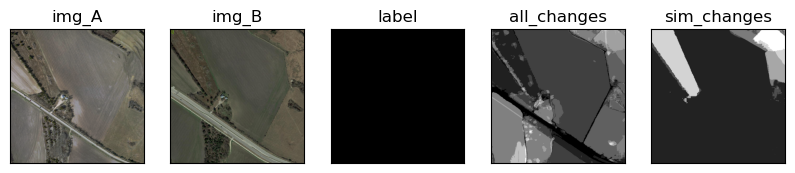

In [13]:
show_prediction_sample(outputs[0], idx=0)

tensor([267., 983.])
tensor([381., 398.])
tensor([  9., 613.])


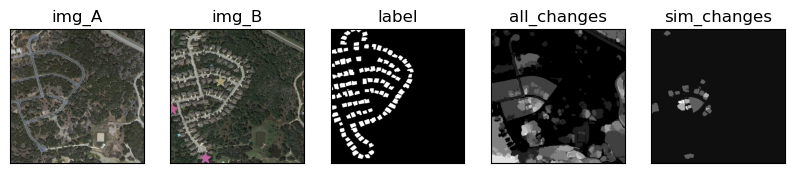

In [14]:
show_prediction_sample(outputs[0], idx=1)

tensor([100.,  83.])
tensor([ 69., 104.])
tensor([113.,  48.])


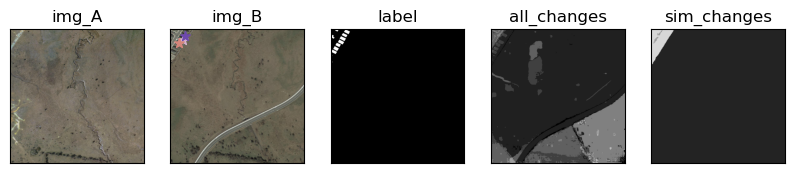

In [15]:
show_prediction_sample(outputs[1], idx=0)

tensor([0., 0.])
tensor([0., 0.])
tensor([0., 0.])


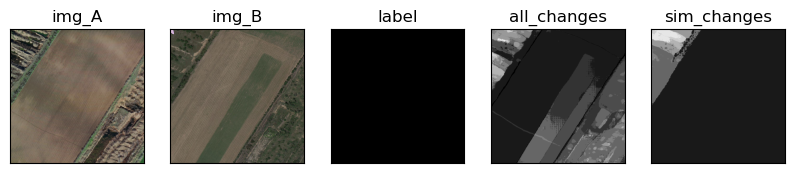

In [16]:
show_prediction_sample(outputs[1], idx=1)

### 2

In [9]:
print(params)

ExperimentParams(model_name='segany', model_type='vit_b', batch_size=2, output_dir='/home/MDizier/projects/stage_stylo_magique_2024/lightning_logs/seganychange/levir-cd/predictions-vit_h', logs_dir='/home/MDizier/projects/stage_stylo_magique_2024/lightning_logs/seganychange/levir-cd/seganychange_repr_change_th', ds_name='levir-cd', th_change_proposals=60, seganychange_version=<SegAnyChangeVersion.AUTHOR: 'v2'>, col_nms_threshold='ci', th_sim=0.8, n_points_grid=1024, prompt_type='sample', n_prompt=3, pred_iou_thresh=0.7, stability_score_thresh=0.7, stability_score_offset=1.0, box_nms_thresh=0.7, min_mask_region_area=0, engine_metric={'iou_type_mAP': 'segm', 'type_decision_mAP': 'ci', 'max_detection_thresholds': [10, 100, 1000]}, exp_id='20240621_171122', exp_name='seganychange_repr_change_th', num_worker=2, n_job_by_node=2, dev=True, loc='random')


tensor([807., 856.])
tensor([393., 174.])
tensor([903.,  97.])


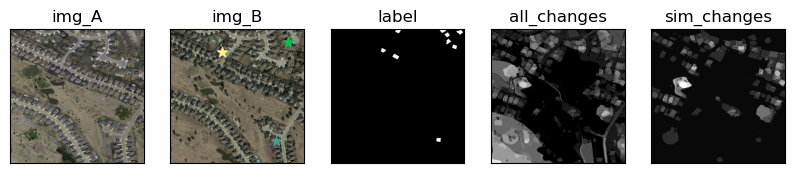

In [10]:
show_prediction_sample(outputs[0], idx=0)

tensor([85., 51.])
tensor([80., 62.])
tensor([57., 52.])


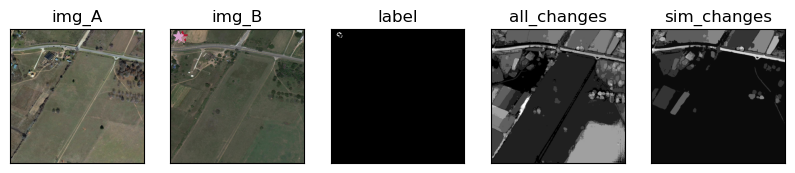

In [11]:
show_prediction_sample(outputs[0], idx=1)

tensor([111., 509.])
tensor([ 928., 1001.])
tensor([882., 922.])


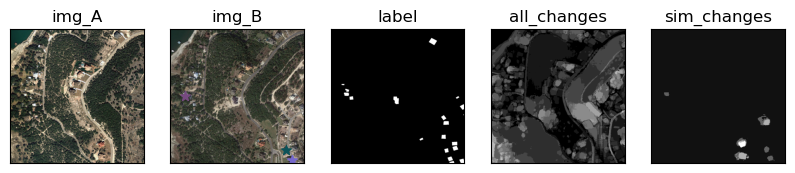

In [12]:
show_prediction_sample(outputs[1], idx=0)

tensor([506., 764.])
tensor([261., 822.])
tensor([172., 783.])


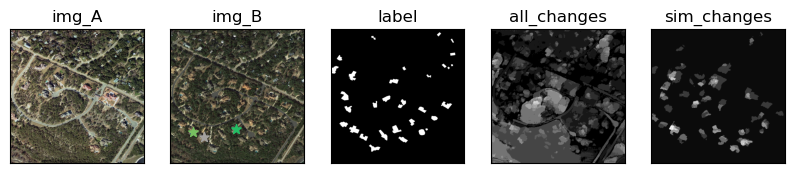

In [13]:
show_prediction_sample(outputs[1], idx=1)

### 1

In [22]:
print(params)

ExperimentParams(model_type='vit_b', batch_size=2, output_dir='/home/MDizier/projects/stage_stylo_magique_2024/lightning_logs/seganychange/levir-cd/predictions-vit_h', logs_dir='/home/MDizier/projects/stage_stylo_magique_2024/lightning_logs/seganychange/levir-cd/seganychange_repr_change_th', ds_name='levir-cd', th_change_proposals=60, seganychange_version=<SegAnyChangeVersion.AUTHOR: 'v2'>, col_nms_threshold='ci', th_sim=0.8, n_points_grid=1024, prompt_type='sample', n_prompt=3, pred_iou_thresh=0.7, stability_score_thresh=0.7, stability_score_offset=1.0, box_nms_thresh=0.7, min_mask_region_area=0, engine_metric={'iou_type_mAP': 'segm', 'type_decision_mAP': 'ci', 'max_detection_thresholds': [10, 100, 1000]}, exp_id='20240621_165330', exp_name='seganychange_repr_change_th', num_worker=2, n_job_by_node=2, dev=True, loc='random')


tensor([813., 850.])
tensor([896.,  47.])
tensor([933., 144.])


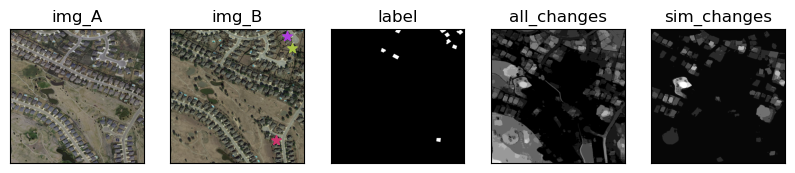

In [23]:
show_prediction_sample(outputs[0], idx=0)

tensor([57., 54.])
tensor([88., 52.])
tensor([80., 61.])


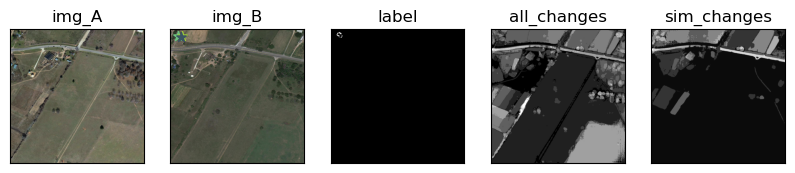

In [24]:
show_prediction_sample(outputs[0], idx=1)

tensor([913., 992.])
tensor([854., 825.])
tensor([884., 936.])


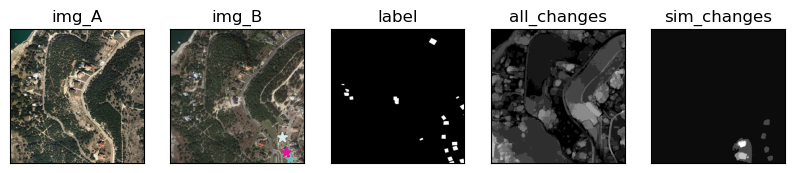

In [25]:
show_prediction_sample(outputs[1], idx=0)

tensor([462., 398.])
tensor([709., 782.])
tensor([902., 300.])


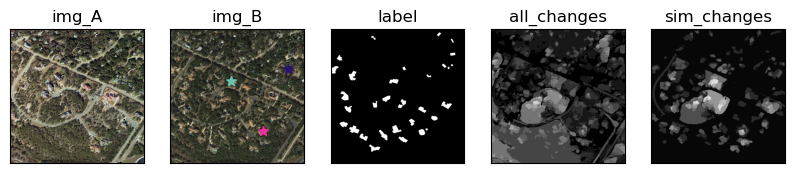

In [26]:
show_prediction_sample(outputs[1], idx=1)

# Annexes

In [4]:
pair_img = load_levircd_sample(1, seed=42)
path_label,path_A, path_B = pair_img.iloc[0]

params = dict(
    batch_size=2,
    ds_name="levir-cd",
    dev=False,
    n_job_by_node=2,
    th_change_proposals=50
)
params = load_exp_params(**params)
print(params)
model = choose_model(is_debug=False, params=params)

output = infer_on_sample(A_path=path_A,
                B_path=path_B, 
                label_path=path_label,
                params=params,
                model=model)

2024-06-19 14:34:50,256 - INFO ::  build vit_h BiSam


ExperimentParams(model_type='vit_h', batch_size=2, output_dir='/home/MDizier/projects/stage_stylo_magique_2024/lightning_logs/seganychange/levir-cd/predictions-vit_h', logs_dir='/home/MDizier/projects/stage_stylo_magique_2024/lightning_logs/seganychange/levir-cd/seganychange_repr_change_th', ds_name='levir-cd', th_change_proposals=50, seganychange_version=<SegAnyChangeVersion.AUTHOR: 'v2'>, col_nms_threshold='ci', points_per_side=32, points_per_batch=64, pred_iou_thresh=0.88, stability_score_thresh=0.95, stability_score_offset=1.0, box_nms_thresh=0.7, min_mask_region_area=0, engine_metric={'iou_type_mAP': 'segm', 'type_decision_mAP': 'ci', 'max_detection_thresholds': [10, 100, 1000]}, exp_id='20240619_143450', exp_name='seganychange_repr_change_th', num_worker=2, n_job_by_node=2, dev=False)


2024-06-19 14:34:55,411 - INFO ::  === v2 ====


BATCH SIZE : 1 * 2
DTYPE input model torch.float32
Function forward Took 16.2692 seconds
sparse_embeddings: torch.Size([2, 1024, 2, 256])
dense_embeddings: torch.Size([2, 1024, 256, 64, 64])
--in transformer--
src : torch.Size([2, 1024, 256, 64, 64])
pos_src : torch.Size([2, 1024, 256, 64, 64])
tokens : torch.Size([2, 1024, 7, 256])
Function predict_masks_batch Took 32.6380 seconds
OUT MODEL : torch.Size([2, 1024, 3, 256, 256])
filter iou_th : 2037
 filter stability_score : 576
 filter mask_threshold : 576
ATTACH 110 masks


2024-06-19 14:35:44,650 - INFO ::  Function generate Took 49.2381 seconds


filter iou_th : 1027
 filter stability_score : 456
 filter mask_threshold : 456
ATTACH 227 masks


2024-06-19 14:35:46,725 - INFO ::  Function temporal_matching_torch Took 2.0714 seconds
2024-06-19 14:35:50,998 - INFO ::  Function temporal_matching_torch Took 4.2717 seconds
2024-06-19 14:35:51,018 - INFO ::  Function proposal_matching_nms Took 0.0087 seconds


NMS masks fusion
masks torch.Size([2, 227, 256, 256])
masks i A torch.Size([110, 256, 256])
masks i B torch.Size([227, 256, 256])
ci torch.Size([2, 227])
bboxes torch.Size([2, 227, 4])
ious torch.Size([2, 227])
masks_logits torch.Size([2, 227, 256, 256])


2024-06-19 14:35:51,213 - INFO ::  Function run Took 55.8009 seconds


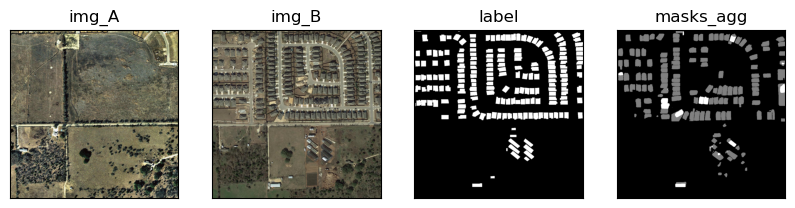

In [5]:
show_prediction_sample(output)

In [38]:
from magic_pen.data.process import generate_grid_prompt

def generate_prompt(mask, dtype: str, n_point, **kwargs) -> torch.Tensor:
    img_size = mask.shape[-1]
    match dtype:
        case "grid":
            point_per_side = int(np.sqrt(n_point)) 
            prompt = torch.as_tensor(generate_grid_prompt(point_per_side, img_size=img_size))
            labels = torch.ones(len(prompt))    
        case "sample":
            loc = kwargs.get('loc', "center")
            prompt, labels = PointSampler().sample(mask, n_point, loc=loc)
        case _:
            raise ValueError("Please provide valid prompt builder name")

    return prompt.to(torch.float32), labels.to(torch.int8)

In [39]:
class PointSampler:
    """Prompt sampler - restricted to points"""
    def sample(self, mask: torch.Tensor, n_point: int, loc: str, **kwargs):

        # empty return
        sample_coords = torch.zeros((n_point, 2))
        
        _register_sample_method = {
            "random": self.draw_random_point,
            "center": self.draw_center_point,
        }
        if loc not in list(_register_sample_method):
            raise ValueError(f"loc method not valid. Valid values for loc : {list(_register_sample_method)}")

        if mask.ndim < 3:
            mask = mask.unsqueeze(0)
            
        # extract shapes from mask
        shapes = extract_object_from_batch(mask).squeeze(0)
        # first check to prevent sum over all the masks
        if shapes.shape[0] > 1 or torch.sum(shapes):
            # draw selected shapes
            id_draw = torch.multinomial(torch.arange(shapes.shape[0], dtype=torch.float), n_point, replacement=False)
            # get the coord of the pixels shapes (M x 3) - M number of not zeros pixels
            coords_candidates = torch.nonzero(shapes[id_draw]).to(torch.float)
            # iterate over the shapes
            sample_coords = torch.stack(
                [
                    # sample on masked data based on shape index - ignore index dim => (N, 2)
                    _register_sample_method[loc](coords_candidates[coords_candidates[:,0] == s][:, 1:])
                for s in torch.unique(coords_candidates[:, 0])]
            )
        # simulate point type (foreground / background)
        labels_points = torch.ones(len(sample_coords))
        
        return sample_coords, labels_points

    def draw_random_point(self, shape):
        """draw one random point from shape"""
        idx = torch.multinomial(torch.arange(shape.shape[0], dtype=torch.float), num_samples=1).squeeze(0)
        return shape[idx]
            
    def draw_center_point(self, shape):
        return torch.mean(shape, dim=0).to(int)

In [40]:
label = output["batch"]["label"]

In [56]:
res, _ = generate_prompt(label, dtype="grid", n_point=10, loc="random")

In [59]:
res

tensor([[170.6667, 170.6667],
        [512.0000, 170.6667],
        [853.3333, 170.6667],
        [170.6667, 512.0000],
        [512.0000, 512.0000],
        [853.3333, 512.0000],
        [170.6667, 853.3333],
        [512.0000, 853.3333],
        [853.3333, 853.3333]])

In [57]:
# invert for sample

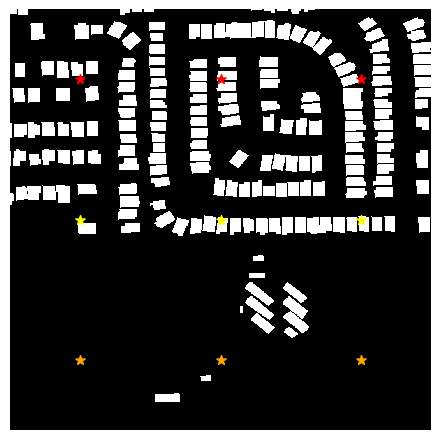

In [58]:
show_img(to_numpy(label.squeeze(0) > 0, transpose=False))
ax = plt.gca()
color = ["red", "yellow", "orange"] * len(res)
pts = to_numpy(res,transpose=False)
for pt,c in zip(pts, color):
    ax.scatter(*pt[::-1], color=c, marker='*', s=50)

## Query Prompt

Seed set to 12


12

In [2]:
from typing import Any, List, Optional, Tuple, Union
import numpy as np
import torch
from segment_any_change.embedding import (
    compute_mask_embedding,
    get_img_embedding_normed,
)
from segment_any_change.masks.mask_items import (
    FilteringType,
    ListProposal,
    change_thresholding,
)
from segment_any_change.matching import (
    neg_cosine_sim,
    neg_cosine_sim_torch,
)
from segment_any_change.sa_dev.utils.amg import MaskData
from segment_any_change.sa_dev_v0.predictor import SamPredictor

from segment_any_change.utils import to_degre, timeit, to_degre_torch
import logging



In [12]:
params = dict(
    batch_size=2,
    ds_name="levir-cd",
    dev=True,
    n_job_by_node=2,
    th_change_proposals=50,
    prompt_type="grid",
    n_prompt=1024,
    loc="random",
    pred_iou_thresh=0.7,
    stability_score_thresh=0.8
)
params = load_exp_params(**params)
print(params)

res = partial_inference(params,
    ds_dtype="test",
    dummy=False,
    indices=np.arange(2),
    return_batch=True,
    in_metrics=None)

2024-06-21 09:11:11,922 - INFO ::  build vit_b BiSam


ExperimentParams(model_type='vit_b', batch_size=2, output_dir='/home/MDizier/projects/stage_stylo_magique_2024/lightning_logs/seganychange/levir-cd/predictions-vit_h', logs_dir='/home/MDizier/projects/stage_stylo_magique_2024/lightning_logs/seganychange/levir-cd/seganychange_repr_change_th', ds_name='levir-cd', th_change_proposals=50, seganychange_version=<SegAnyChangeVersion.AUTHOR: 'v2'>, col_nms_threshold='ci', prompt_type='grid', n_prompt=1024, pred_iou_thresh=0.7, stability_score_thresh=0.8, stability_score_offset=1.0, box_nms_thresh=0.7, min_mask_region_area=0, engine_metric={'iou_type_mAP': 'segm', 'type_decision_mAP': 'ci', 'max_detection_thresholds': [10, 100, 1000]}, exp_id='20240621_091111', exp_name='seganychange_repr_change_th', num_worker=2, n_job_by_node=2, dev=True, loc='random')
DATASET SUBSET : 2


Processing:   0%|                                                                                         | 0/1 [00:00<?, ?it/s]2024-06-21 09:11:13,367 - INFO ::  === v2 ====


BATCH SIZE : 2 * 2
dict_keys(['img_A', 'img_B', 'label', 'index', 'point_coords', 'point_labels'])
Mode : auto
DTYPE input model torch.float32
Function forward Took 6.7005 seconds
sparse_embeddings: torch.Size([4, 1024, 2, 256])
dense_embeddings: torch.Size([4, 1024, 256, 64, 64])
--in transformer--
src : torch.Size([4, 1024, 256, 64, 64])
pos_src : torch.Size([4, 1024, 256, 64, 64])
tokens : torch.Size([4, 1024, 7, 256])
Function predict_masks_batch Took 60.0866 seconds
OUT MODEL : torch.Size([4, 1024, 3, 256, 256])
:: raw masks : 3072 ::
 filter iou_th : 2375
 filter stability_score : 751
 filter mask_threshold : 751
ATTACH 232 masks
:: raw masks : 3072 ::
 filter iou_th : 2005
 filter stability_score : 541
 filter mask_threshold : 541
ATTACH 336 masks
:: raw masks : 3072 ::
 filter iou_th : 2120


2024-06-21 09:12:20,781 - INFO ::  Function generate Took 67.4125 seconds


 filter stability_score : 612
 filter mask_threshold : 612
ATTACH 260 masks
:: raw masks : 3072 ::
 filter iou_th : 1687
 filter stability_score : 631
 filter mask_threshold : 631
ATTACH 402 masks


2024-06-21 09:12:24,139 - INFO ::  Function temporal_matching_torch Took 3.3524 seconds
2024-06-21 09:12:27,935 - INFO ::  Function temporal_matching_torch Took 3.7947 seconds
2024-06-21 09:12:27,960 - INFO ::  Function proposal_matching_nms Took 0.0091 seconds


NMS masks fusion
masks torch.Size([2, 260, 256, 256])
masks i A torch.Size([232, 256, 256])
masks i B torch.Size([260, 256, 256])
ci torch.Size([2, 260])
bboxes torch.Size([2, 260, 4])
ious torch.Size([2, 260])
masks_logits torch.Size([2, 260, 256, 256])


2024-06-21 09:12:32,780 - INFO ::  Function temporal_matching_torch Took 4.8028 seconds
2024-06-21 09:12:38,535 - INFO ::  Function temporal_matching_torch Took 5.7538 seconds
2024-06-21 09:12:38,564 - INFO ::  Function proposal_matching_nms Took 0.0106 seconds


NMS masks fusion
masks torch.Size([2, 402, 256, 256])
masks i A torch.Size([336, 256, 256])
masks i B torch.Size([402, 256, 256])
ci torch.Size([2, 402])
bboxes torch.Size([2, 402, 4])
ious torch.Size([2, 402])
masks_logits torch.Size([2, 402, 256, 256])


2024-06-21 09:12:39,103 - INFO ::  Function run Took 85.7348 seconds


update : classif


Processing: 100%|█████████████████████████████████████████████████████████████████████████████████| 1/1 [01:26<00:00, 86.71s/it]

-


In [13]:
res[0].keys()

dict_keys(['pred', 'metrics', 'batch'])

In [14]:
out = res[0]

---

In [6]:
from segment_any_change.model import BiSam, SamModeInference
from segment_any_change.utils import load_sam
from magic_pen.config import DEVICE

sam = load_sam(
    model_type="vit_h", 
    model_cls=BiSam, 
    version="dev", 
    device=DEVICE
)

2024-06-21 08:52:45,745 - INFO ::  build vit_h BiSam


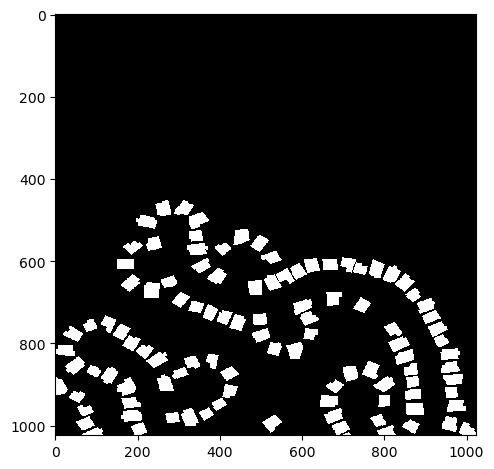

In [7]:
show_img(to_numpy(out["batch"]["label"][1].squeeze(0) > 0, transpose=False), show_axis=True)


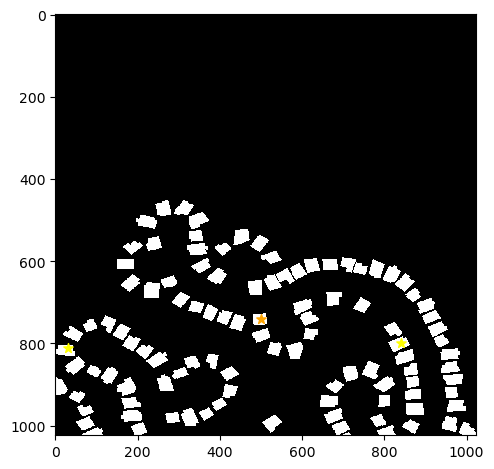

In [8]:
show_img(to_numpy(out["batch"]["label"][1].squeeze(0) > 0, transpose=False), show_axis=True)

ax = plt.gca()
n_pts = 3
color = ["yellow", "orange"] * n_pts
pts = np.array([
    [810, 30],
    [740, 500],
    [800, 840]
])
for pt,c in zip(pts, color):
    ax.scatter(*pt[::-1], color=c, marker='*', s=50)

In [9]:
pts = pts[:, ::-1]
pts

array([[ 30, 810],
       [500, 740],
       [840, 800]])

In [10]:
new_batch = out["batch"].copy()

query_points = np.array([
    [810, 30],
    [740, 500],
    [800, 840]
])
query_points = query_points[:, ::-1].copy()

new_batch["point_coords"] = torch.as_tensor(query_points, dtype=torch.float).repeat(params.batch_size, 1, 1)
new_batch["point_labels"] = torch.ones((params.batch_size, len(query_points)))

In [11]:
new_batch["point_coords"].shape

torch.Size([2, 3, 2])

In [12]:
new_batch["img_B"].shape

torch.Size([2, 3, 1024, 1024])

In [13]:
outputs = sam(
    batched_input=new_batch, 
    multimask_output=True, 
    return_logits=True,
    mode=SamModeInference.INTERACTIVE
)
new_masks, iou_predictions = outputs.values()
new_masks = new_masks > 0.
# prevent image encoder to recompute images embeddings

Mode : auto
DTYPE input model torch.float32
Function forward Took 15.1186 seconds
sparse_embeddings: torch.Size([2, 3, 2, 256])
dense_embeddings: torch.Size([2, 3, 256, 64, 64])
--in transformer--
src : torch.Size([2, 3, 256, 64, 64])
pos_src : torch.Size([2, 3, 256, 64, 64])
tokens : torch.Size([2, 3, 7, 256])
Function predict_masks_batch Took 0.1830 seconds


In [14]:
new_masks.shape

torch.Size([2, 3, 3, 256, 256])

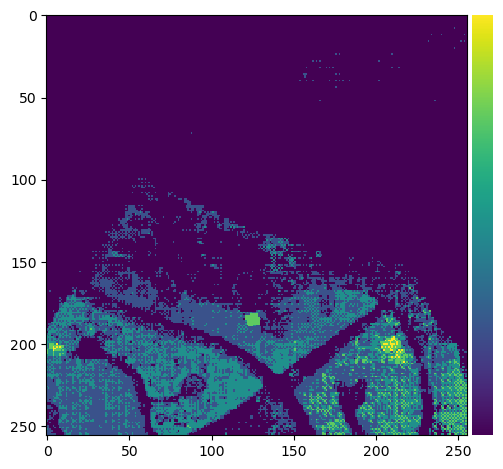

In [17]:
show_img(to_numpy(new_masks[1].flatten(0, 1).sum(dim=0), transpose=False))

In [18]:
iou_predictions.shape

torch.Size([2, 3, 3])

In [19]:
torch.argmax(iou_predictions, dim=2, keepdim=True).shape

torch.Size([2, 3, 1])

In [20]:
_, max_indices = torch.max(iou_predictions, dim=2)


In [21]:
new_masks.shape

torch.Size([2, 3, 3, 256, 256])

In [22]:
max_indices_expanded = max_indices.unsqueeze(-1).unsqueeze(-1).unsqueeze(-1).expand(-1, -1, -1, *new_masks.shape[-2:])
max_indices_expanded.shape


torch.Size([2, 3, 1, 256, 256])

In [23]:
best_masks = new_masks.gather(2, max_indices_expanded).squeeze(2)

In [24]:
best_masks.shape

torch.Size([2, 3, 256, 256])

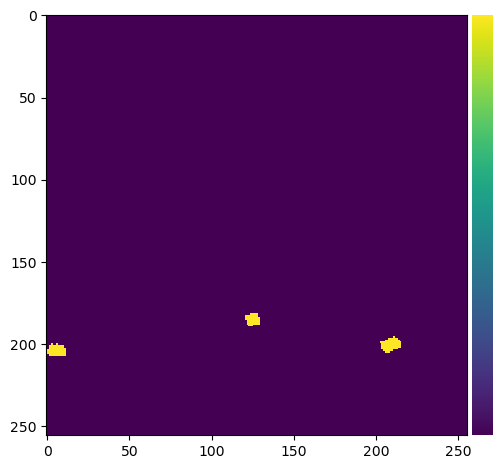

In [25]:
show_img(to_numpy(best_masks[1].sum(dim=0), transpose=False))

In [26]:
best_masks.shape

torch.Size([2, 3, 256, 256])

In [27]:
from segment_any_change.masks.mask_items import ImgType

def get_img_embedding_normed(model: Any, img_type: ImgType=None) -> torch.Tensor:
    """Invert affine transformation of the image encoder last LayerNorm Layer.
    Run for a batch


    Args:
        predictor (SamPredictor, BiSam): inference class for SAM

    Returns:
        np.ndarray: Scaled embedding
    """
    # workaround BiSam - not clean
    if type(model).__name__ == "BiSam":
        embedding = model.get_image_embedding(img_type)
        print(embedding.shape)
    else:
        raise RuntimeError(f"Not implemented for {type(model).__name__}")
    # check for batch ==1
    # get last layerNorm weights & biais to invert affine transformation
    w = model._modules["image_encoder"].neck[3].weight
    b = model._modules["image_encoder"].neck[3].bias
    embedding = (embedding - b[:, None, None]) / w[:, None, None]
    return embedding.detach()

In [28]:
imgs_embedding_B = get_img_embedding_normed(sam)

torch.Size([2, 256, 64, 64])


In [29]:
imgs_embedding_B.shape

torch.Size([2, 256, 64, 64])

In [30]:
best_masks.shape

torch.Size([2, 3, 256, 256])

In [31]:
# imgB at position 1 in batch best_masks

In [32]:
masks_embedding = compute_mask_embedding(best_masks, imgs_embedding_B)

In [47]:
# mean of embedding
masks_embedding = masks_embedding.mean(dim=1)


In [48]:
masks_embedding.shape

torch.Size([2, 256])

In [49]:
masks_embedding.mean(dim=1).shape

torch.Size([2])

In [50]:
out["pred"].keys()

dict_keys(['masks', 'proposal_emb', 'iou_preds', 'confidence_scores', 'data'])

In [51]:
proposal_emb = out["pred"]["proposal_emb"]

In [52]:
proposal_emb.shape

torch.Size([2, 46, 256])

In [53]:
proposal_emb.sum(dim=(2))

tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         -1.3351e-05,  1.2159e-05,  1.5259e-05,  1.0133e-05,  2.6226e-06,
         -1.1206e-05,  4.0531e-05,  1.6928e-05,  1.1921e-05,  9.0599e-06,
          1.3113e-05, -1.3590e-05,  4.4823e-05,  3.5763e-05,  4.8637e-05,
          5.1498e-05,  4.3154e-05,  1.7166e-05,  3.0696e-05,  4.7684e-06,
          3.3379e-05,  1.2398e-05,  1.5736e-05, -8.8573e-05,  2.1458e-06,
          8.5831e-06,  5.7220e-06,  7.6294e-06,  1.4305e-06,  4.7684e-07,
          0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  4.5538e-05,
          3.7432e-05,  3.5763e-06,  1.4544e-05, -6.4373e-05, -4.1008e-05,
         -1.8597e-05,  5.1022e-05, -5.7220e-06, -1.2875e-05,  1.3828e-05,
          4.0531e-05,  9.0599e-06,  4.1246e-05,  4.6492e-05, -3.1233e-05,
         -2.360

In [56]:
masks_embedding.shape

torch.Size([2, 256])

In [57]:
proposal_emb.shape

torch.Size([2, 46, 256])

In [64]:
torch.linalg.norm(masks_embedding[1])

tensor(12.6350)

In [65]:
x1 = masks_embedding[1]
x2 = proposal_emb[1]

norm_1 = torch.linalg.norm(x1)
norm_2 = torch.linalg.norm(x2, dim=1)

dot_prod = (x1 @ x2.permute(1, 0))
# vectors norms with expanded dims
dot_prod

tensor([  0.0000,   0.0000,   0.0000,   0.0000,  -5.5923,  -5.1457, -16.9344,
        -17.3297,  14.2962,   6.3296,   6.1532,  -2.2355,  11.0176,  12.6313,
         -5.1123,  -4.2284,  -4.2299,  -4.9053,   5.4207,  -1.6285,  -1.0752,
        -17.0602,  -2.1242, -17.3310,  -5.1744,  -5.3159, -15.8345,   5.9231,
        -11.9830, -10.5392, -11.4093, -10.6340, -10.9885, -11.7309,  -7.2686,
        -16.5317, -14.4801,   0.6191,  -0.3936,  -9.5159,  -0.3905,  -5.0292,
        -10.3664,  -4.6749,  -6.2325,  -4.2766])

In [83]:
norm_1

tensor(12.6350)

In [84]:
norm_1 * norm_2

tensor([  0.0000,   0.0000,   0.0000,   0.0000, 151.1815, 147.5632, 198.8871,
        198.2207, 163.0387, 177.0507, 175.9531, 154.3141, 185.3502, 181.3557,
        169.0987, 159.5884, 166.2843, 180.1351, 168.9056, 124.7338, 178.7722,
        194.6823, 136.6943, 159.6251, 160.3629, 166.2133, 181.8186, 145.6011,
        199.3010, 186.2363, 191.9364, 184.4159, 179.7820, 190.8785, 157.6511,
        194.7347, 197.1313, 129.2035, 151.0691, 169.2456, 152.0373, 163.4092,
        172.6324, 160.0476, 152.9678, 156.1759])

In [85]:
norm_1.unsqueeze(0).unsqueeze(1).expand(-1, norm_2.shape[0]) * norm_2

tensor([[  0.0000,   0.0000,   0.0000,   0.0000, 151.1815, 147.5632, 198.8871,
         198.2207, 163.0387, 177.0507, 175.9531, 154.3141, 185.3502, 181.3557,
         169.0987, 159.5884, 166.2843, 180.1351, 168.9056, 124.7338, 178.7722,
         194.6823, 136.6943, 159.6251, 160.3629, 166.2133, 181.8186, 145.6011,
         199.3010, 186.2363, 191.9364, 184.4159, 179.7820, 190.8785, 157.6511,
         194.7347, 197.1313, 129.2035, 151.0691, 169.2456, 152.0373, 163.4092,
         172.6324, 160.0476, 152.9678, 156.1759]])

In [82]:
norm_2

tensor([ 0.0000,  0.0000,  0.0000,  0.0000, 11.9653, 11.6789, 15.7409, 15.6882,
        12.9037, 14.0127, 13.9258, 12.2132, 14.6696, 14.3534, 13.3833, 12.6307,
        13.1606, 14.2568, 13.3681,  9.8721, 14.1490, 15.4082, 10.8187, 12.6336,
        12.6919, 13.1550, 14.3901, 11.5236, 15.7737, 14.7397, 15.1908, 14.5956,
        14.2289, 15.1071, 12.4773, 15.4123, 15.6020, 10.2258, 11.9564, 13.3950,
        12.0330, 12.9331, 13.6630, 12.6670, 12.1067, 12.3606])

In [81]:
x1 = masks_embedding[1]
x2 = proposal_emb[1]

norm_1 = torch.linalg.norm(x1)
norm_2 = torch.linalg.norm(x2, dim=1)

dot_prod = (x1 @ x2.permute(1, 0))
# vectors norms with expanded dims
#dm = norm_1.unsqueeze(1).expand(-1, norm_2.shape[0]) * norm_2.unsqueeze(0).expand(norm_1.shape[0], -1)
dm = norm_1.unsqueeze(0).unsqueeze(1).expand(-1, norm_2.shape[0]) * norm_2
(dot_prod / dm).shape

torch.Size([1, 46])

In [39]:
norm_1 = torch.linalg.norm(x1, dim=1)
print(norm_1)
norm_1.unsqueeze(1).expand(-1, norm_2.shape[0])

tensor([13.4766, 12.8870, 13.0592])


tensor([[13.4766, 13.4766, 13.4766, 13.4766, 13.4766, 13.4766, 13.4766, 13.4766,
         13.4766, 13.4766, 13.4766, 13.4766, 13.4766, 13.4766, 13.4766, 13.4766,
         13.4766, 13.4766, 13.4766, 13.4766, 13.4766, 13.4766, 13.4766, 13.4766,
         13.4766, 13.4766, 13.4766, 13.4766, 13.4766, 13.4766, 13.4766, 13.4766,
         13.4766, 13.4766, 13.4766, 13.4766, 13.4766, 13.4766, 13.4766, 13.4766,
         13.4766, 13.4766, 13.4766, 13.4766, 13.4766, 13.4766],
        [12.8870, 12.8870, 12.8870, 12.8870, 12.8870, 12.8870, 12.8870, 12.8870,
         12.8870, 12.8870, 12.8870, 12.8870, 12.8870, 12.8870, 12.8870, 12.8870,
         12.8870, 12.8870, 12.8870, 12.8870, 12.8870, 12.8870, 12.8870, 12.8870,
         12.8870, 12.8870, 12.8870, 12.8870, 12.8870, 12.8870, 12.8870, 12.8870,
         12.8870, 12.8870, 12.8870, 12.8870, 12.8870, 12.8870, 12.8870, 12.8870,
         12.8870, 12.8870, 12.8870, 12.8870, 12.8870, 12.8870],
        [13.0592, 13.0592, 13.0592, 13.0592, 13.0592, 13.0592,

In [40]:
x2[0]

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 

proposal embedding could be 0 ??
* => a cause du pad_sequence ?

In [35]:
from magic_pen.utils_io import save_pickle, load_pickle

save_pickle(out, "tmp.pkl")

### test

In [1]:
from segment_any_change.query_prompt import QueryPointMecanism, SegAnyPrompt

ImportError: cannot import name 'ListProposal' from 'segment_any_change.masks.mask_items' (/home/MDizier/projects/stage_stylo_magique_2024/src/segment_any_change/masks/mask_items.py)

In [ ]:
import numpy as np
import cv2
from PIL import Image
import torch
from magic_pen.config import SEED
import pytorch_lightning as pl
import pandas as pd
import os
from copy import deepcopy
import torch.nn.functional as F
from torchmetrics import Metric
from tqdm import tqdm
import torch
import matplotlib.pyplot as plt

from magic_pen.utils_io import load_levircd_sample

from magic_pen.data.loader import BiTemporalDataset
from commons.constants import NamedDataset
from magic_pen.data.loader import BiTemporalDataset
from magic_pen.data.process import DefaultTransform

from segment_any_change.masks.mask_process import extract_object_from_batch
from segment_any_change.config_run import ExperimentParams, choose_model, load_default_metrics, load_exp_params
from segment_any_change.eval import MetricEngine
from segment_any_change.inference import load_partial_ds
from segment_any_change.config_run import load_default_exp_params
from segment_any_change.utils import to_numpy, SegAnyChangeVersion, show_img, show_pair_img, show_prediction_sample

from magic_pen.utils_io import save_pickle, load_pickle

from segment_any_change.inference import partial_inference, infer_on_sample

pl.seed_everything(seed=SEED)

In [3]:
out = load_pickle("tmp.pkl")

In [4]:
out["pred"].keys()

dict_keys(['masks', 'proposal_emb', 'iou_preds', 'confidence_scores', 'data'])

In [5]:
data = out["pred"]["data"]

In [6]:
out["pred"]["proposal_emb"].shape

torch.Size([2, 407, 256])

In [7]:
from segment_any_change.model import BiSam, SamModeInference
from segment_any_change.utils import load_sam
from magic_pen.config import DEVICE

sam = load_sam(
    model_type="vit_h", 
    model_cls=BiSam, 
    version="dev", 
    device=DEVICE
)

2024-06-21 09:54:05,606 - INFO ::  build vit_h BiSam


In [62]:
params = dict(
    batch_size=2,
    ds_name="levir-cd",
    dev=True,
    n_job_by_node=2,
    th_change_proposals=50,
    prompt_type="grid",
    n_prompt=1024,
    loc="random",
    pred_iou_thresh=0.7,
    stability_score_thresh=0.8
)
params = load_exp_params(**params)
print(params)

ExperimentParams(model_type='vit_b', batch_size=2, output_dir='/home/MDizier/projects/stage_stylo_magique_2024/lightning_logs/seganychange/levir-cd/predictions-vit_h', logs_dir='/home/MDizier/projects/stage_stylo_magique_2024/lightning_logs/seganychange/levir-cd/seganychange_repr_change_th', ds_name='levir-cd', th_change_proposals=0, seganychange_version=<SegAnyChangeVersion.AUTHOR: 'v2'>, col_nms_threshold='ci', prompt_type='grid', n_prompt=1024, pred_iou_thresh=0.7, stability_score_thresh=0.8, stability_score_offset=1.0, box_nms_thresh=0.7, min_mask_region_area=0, engine_metric={'iou_type_mAP': 'segm', 'type_decision_mAP': 'ci', 'max_detection_thresholds': [10, 100, 1000]}, exp_id='20240621_100306', exp_name='seganychange_repr_change_th', num_worker=2, n_job_by_node=2, dev=True, loc='random')


In [63]:
items_change = out["pred"]

new_batch = out["batch"].copy()

query_points = np.array([
    [810, 30],
    [740, 500],
    [800, 840]
])
query_points = query_points[:, ::-1].copy()

new_batch["point_coords"] = torch.as_tensor(query_points, dtype=torch.float).repeat(params.batch_size, 1, 1)
new_batch["point_labels"] = torch.ones((params.batch_size, len(query_points)))

query_engine = QueryPointMecanism(items_change, model=sam, th_sim=85)

In [52]:
items_change.keys()

dict_keys(['masks', 'proposal_emb', 'iou_preds', 'confidence_scores', 'data'])

In [53]:
query_res = query_engine.run(new_batch)

Mode : auto
DTYPE input model torch.float32
Function forward Took 13.1205 seconds
sparse_embeddings: torch.Size([2, 3, 2, 256])
dense_embeddings: torch.Size([2, 3, 256, 64, 64])
--in transformer--
src : torch.Size([2, 3, 256, 64, 64])
pos_src : torch.Size([2, 3, 256, 64, 64])
tokens : torch.Size([2, 3, 7, 256])
Function predict_masks_batch Took 0.1453 seconds
torch.Size([2, 256])
torch.Size([2, 407, 256])
2
torch.Size([407, 1024, 1024])
torch.Size([407])
torch.Size([407, 1024, 1024])
torch.Size([407])


Objets changeants similaires aux prompts

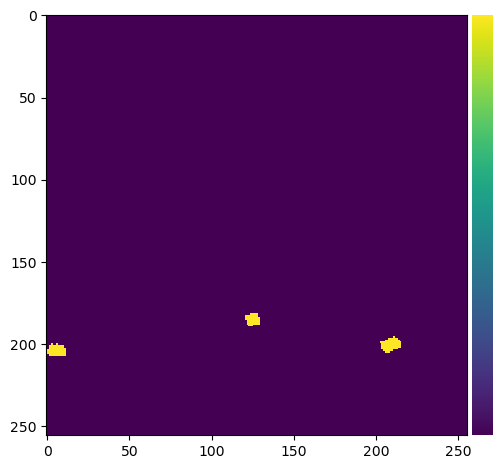

In [59]:
show_img(to_numpy(query_res["prompt_masks"][1].sum(dim=0), transpose=False))

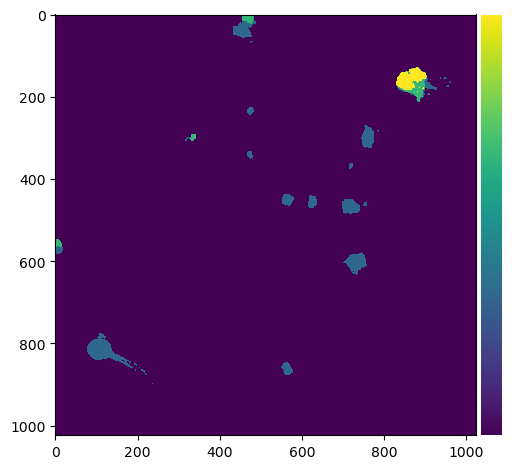

In [60]:
show_img(to_numpy(query_res["masks"][1].sum(dim=0), transpose=False))

Tout changements

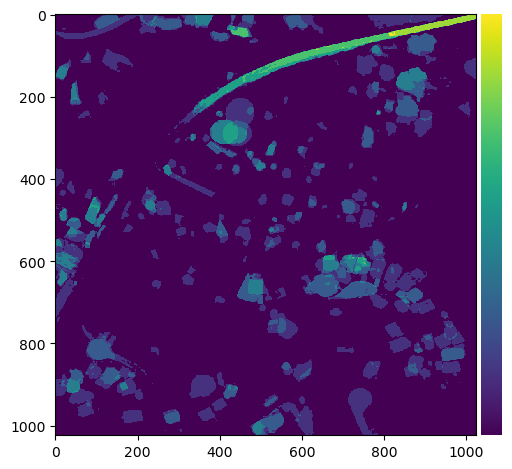

In [61]:
show_img(to_numpy(out["pred"]["masks"][1].sum(dim=0), transpose=False))

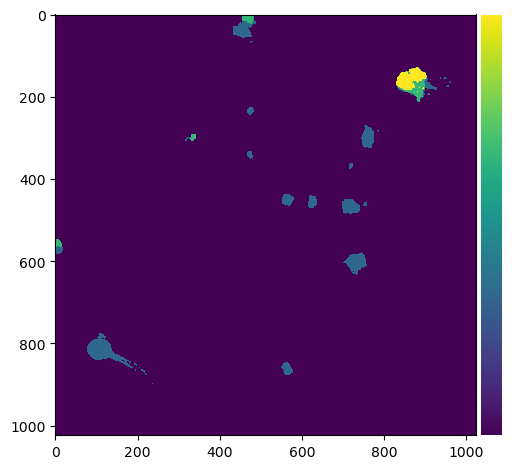

In [106]:
show_img(to_numpy(query_res["masks"][1].sum(dim=0), transpose=False)) 

In [ ]:
query_res.shape

In [ ]:
query_res["masks"].shape

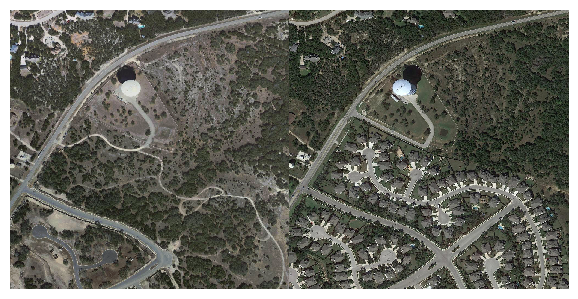

In [31]:
show_pair_img(to_numpy(new_batch["img_A"][1] / 255, transpose=True), to_numpy(new_batch["img_B"][1] / 255, transpose=True))

In [64]:
query_res["prompt_masks"].shape

torch.Size([2, 3, 256, 256])

In [70]:
from segment_any_change.utils import resize

p_masks = resize(query_res["prompt_masks"], (1024, 1024))


In [78]:
p_masks.shape

torch.Size([2, 3, 1024, 1024])

In [66]:
query_res["masks"].shape

torch.Size([2, 22, 1024, 1024])

In [84]:
t = torch.cat([query_res["masks"], p_masks], dim=1)

In [87]:
query_res["masks"][0].sum(dim=(1, 2))

tensor([519, 327, 558, 110, 896,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0])

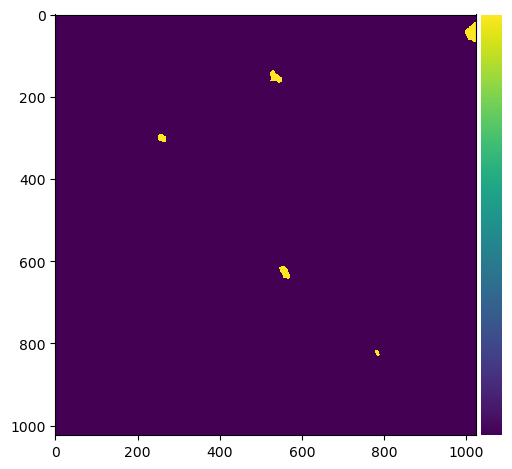

In [94]:
show_img(to_numpy(query_res["masks"][0].sum(dim=0), transpose=False))

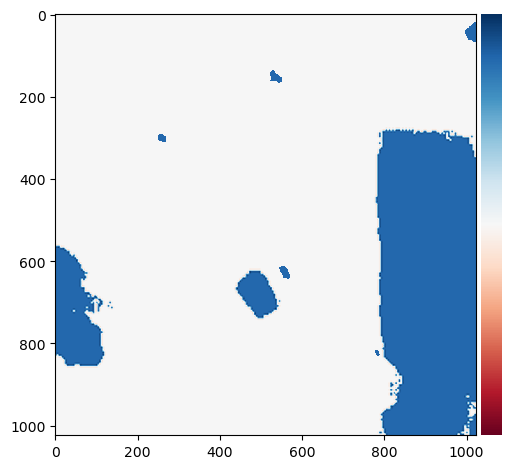

In [95]:
show_img(to_numpy(t[0].sum(dim=0), transpose=False))